##1. Install necessary libraries

In [1]:
!pip install faiss-cpu
!pip install langchain chromadb openai newspaper3k
!pip install beautifulsoup4 requests langchain
# Install LangChain community
!pip install -U langchain-community
# Install ChromaDB
!pip install chromadb
# Install OpenAI
!pip install openai
# Install langchain openai
!pip install langchain_openai
# Install langchain
!pip install -U langchain langchain-
# Sequence Transformer
!pip install sentence-transformers

!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s e

##2. Impliment functional code

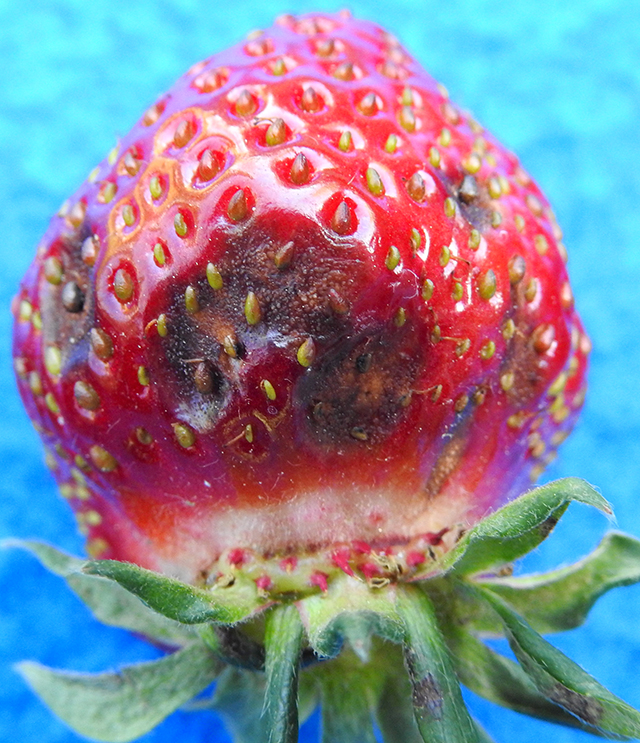

Creating GPT Image Description...

GPT Symptom Description:
 This strawberry displays several visible symptoms:  1. **Color Variations**: The berry features
normal bright red areas, but there is a significant portion that appears dark brown or black,
indicating decaying or diseased tissue.  2. **Texture Changes**: The affected area looks sunken and
softer compared to the healthy red parts, which are firm with the typical seed-studded surface.  3.
**Spots and Markings**: There are numerous brown to black spots concentrated mainly in the affected
area. These spots might suggest a fungal or bacterial issue but are distinctly localized rather than
spread across the entire fruit.  Overall, these symptoms point toward potential rot or a localized
infection affecting the integrity and aesthetics of the strawberry.

Creating Document Supported Response...

Final Diagnosis:
 Based on the symptoms described and the reference information provided, the most likely disease
affecting the strawberry 

In [22]:
import base64
import textwrap
import openai
import os
import requests
from PIL import Image as PILImage
from IPython.display import display

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings
from bs4 import BeautifulSoup
from langchain.docstore.document import Document

import re

# Create API connection
api_key = " "  # Replace with your OpenAI api key
os.environ["OPENAI_API_KEY"] = api_key
client = openai.OpenAI(api_key=api_key)

# Web Scarape for urls
def scrape_clean_text(url):
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")

        containers = [soup.find("article"), soup.find("main"), soup.find("div", {"class": "content"}), soup.body]
        for container in containers:
            if container:
                text = container.get_text(separator="\n").strip()
                if len(text.split()) > 100:
                    return Document(page_content=text, metadata={"source": url})
        return None
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")
        return None

# Uses GPT to create a image description
def describe_strawberry_image(image_path, client):
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are a plant pathology assistant. Describe only the **visible symptoms** "
                    "of this strawberry. Mention color, texture, spots, fuzz, rot, etc. "
                    "Do NOT guess the disease."
                )
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Describe the symptoms of this strawberry."},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]
            }
        ],
        max_tokens=300
    )
    return response.choices[0].message.content.strip()


# Load your local PDF file
pdf_path = "/content/strawberry_diseases.pdf"  # change this to your actual file path
loader = PyPDFLoader(pdf_path)

# Load and split PDF into documents
clean_docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = splitter.split_documents(clean_docs)

embeddings = OpenAIEmbeddings()
# limited_splits = splits[:5]
vectorstore = FAISS.from_documents(splits, embeddings)
retriever = vectorstore.as_retriever()

# Uses GPT response to search the scraped docs for a disease solution
template = """You are a strawberry disease expert.

Based on the following symptoms and reference information, identify the most likely disease. Explain your reasoning.

Symptoms:
{symptoms}

Reference Info:
{context}
"""
prompt = PromptTemplate.from_template(template)

llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0)
rag_chain = (
    {
        "symptoms": RunnablePassthrough(),
        "context": retriever | (lambda docs: "\n\n".join(d.page_content for d in docs))
    }
    | prompt
    | llm
    | StrOutputParser()
)

# Main
def main(image_path):
    img = PILImage.open(image_path)
    display(img)

    print("Creating GPT Image Description...")
    symptoms = describe_strawberry_image(image_path, client)
    print("\nGPT Symptom Description:\n", textwrap.fill(symptoms, 100))

    print("\nCreating Document Supported Response...")
    diagnosis = rag_chain.invoke(symptoms)

    print("\nFinal Diagnosis:\n", textwrap.fill(diagnosis, 100))

# Invoke main with img path
main("/content/bad-strawberry15.jpg")